In [ ]:
"""
This file contains the code for the model used in the report about Agent Based Models.
The model is made out of both a 2d graph and a network, which together pull and push the agents
towards certain political positions.

08-02-2022
"""

In [43]:
import time, enum, math
import random
import numpy as np
import pandas as pd
import pylab as plt
import mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mesa import Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa import Agent
from scipy.spatial import distance, distance_matrix
from collections import defaultdict
import networkx.algorithms.community as nx_comm

In [44]:
def plots2(positions, num_parties, model, num_steps, campaign_type, radius):

    #for step in range(0,int(num_steps/2), int(((num_steps/2)/10))):
    step = num_steps
    positions_step = positions.xs(step, level="Step")["Position"]

    test = positions_step.to_numpy()

    positions_array = np.empty((0, 2), int)
    for i in range(num_voter+num_parties):
        test2=np.asarray(test[i])
        positions_array = np.append(positions_array, [test2], axis=0)

    positions_split = np.split(positions_array, [num_voter])
    positions_voters = positions_split[0]
    positions_parties = positions_split[1]

    dictionairy_parties = {}

    for i in range(len(positions_voters)):
        dist_mat = distance_matrix(positions_voters , positions_parties)[i,:]
        if np.argmin(dist_mat) in dictionairy_parties:
            dictionairy_parties[np.argmin(dist_mat)] = np.vstack([dictionairy_parties[np.argmin(dist_mat)],positions_voters[i]])
        else:
            dictionairy_parties[np.argmin(dist_mat)] = [positions_voters[i]]


    fig, ax = plt.subplots(constrained_layout=True)

    number_voters_parties = {}
    for party in dictionairy_parties:

        position_voters_1party = dictionairy_parties.get(party)
        position_voters_1party = np.array(position_voters_1party)

        ax.scatter(position_voters_1party[:,0], position_voters_1party[:,1], label='party {i}'.format(i=party+1))

        number_voters_1party = len(position_voters_1party)

        number_voters_parties[party] = number_voters_1party

    ax.scatter(positions_parties[:,0], positions_parties[:,1], c='k', s=200)

    for i in range(num_parties):
        if campaign_type == 'close':
            a = plt.Circle((positions_parties[:,0][i], positions_parties[:,1][i]), radius, fill=False)
            plt.gca().add_artist(a)

        ax.set_xlabel('Libertarian')
        ax.set_ylabel('Left')

    secax_x = ax.secondary_xaxis('top')
    secax_x.set_xlabel('Authoritarian')

    secax_y = ax.secondary_yaxis('right')
    secax_y.set_ylabel('Right')

    plt.xlim(0, height_width)
    plt.ylim(0, height_width)
    plt.axvline(x=height_width/2)
    plt.axhline(y=height_width/2)
    plt.title('Election with different parties')
    plt.legend()
    plt.show()

    print(number_voters_parties)
    max_key = max(number_voters_parties, key=number_voters_parties.get)


    print('Party', max_key+1, 'won with', number_voters_parties[max_key], 'votes of the',  num_voter, 'votes')

def plots_during_steps(positions, num_parties, model, num_steps, campaign_type, radius, num_voter, height_width):
    """plots the parties and voters during the steps"""
    
    step = num_steps
    positions_step = positions.xs(step, level="Step")["Position"]
    
    number_voters_parties, positions = plots(positions_step, num_parties, model, num_steps, campaign_type, radius, num_voter, height_width)
    
    return number_voters_parties, positions
    
def plots_during_instant_runoff(number_voters_parties, positions, num_parties, model, num_steps, campaign_type, radius, num_voter, height_width):
    """plots the parties and voters during the instant runoff election"""
    min_key = min(number_voters_parties, key=number_voters_parties.get)

    positions = positions.drop([num_voter+min_key])
    positions = positions.reset_index(drop=True)

    number_voters_parties, positions = plots(positions, num_parties, model, num_steps, campaign_type, radius, num_voter, height_width)
    
    return number_voters_parties, positions


def plots(positions, num_parties, model, num_steps, campaign_type, radius, num_voter, height_width):
    """calculates the outcome for the election and creates the plots of the current politcal landscape"""
    
    position_np = positions.to_numpy()

    positions_array = np.empty((0, 2), int)
    for i in range(len(position_np)):
        position_np2=np.asarray(position_np[i])
        positions_array = np.append(positions_array, [position_np2], axis=0)

    positions_split = np.split(positions_array, [num_voter])
    positions_voters = positions_split[0]
    positions_parties = positions_split[1]

    dictionairy_parties = {}

    for i in range(len(positions_voters)):
        dist_mat = distance_matrix(positions_voters , positions_parties)[i,:]
        if np.argmin(dist_mat) in dictionairy_parties:
            dictionairy_parties[np.argmin(dist_mat)] = np.vstack([dictionairy_parties[np.argmin(dist_mat)],positions_voters[i]])
        else:
            dictionairy_parties[np.argmin(dist_mat)] = [positions_voters[i]]


    #fig, ax = plt.subplots(constrained_layout=True)
    
    #in this variable is the outcome of the election
    number_voters_parties = {}
    for party in dictionairy_parties:

        position_voters_1party = dictionairy_parties.get(party)
        position_voters_1party = np.array(position_voters_1party)

        #ax.scatter(position_voters_1party[:,0], position_voters_1party[:,1], label='party {i}'.format(i=party+1))

        number_voters_1party = len(position_voters_1party)

        number_voters_parties[party] = number_voters_1party
    
    """
    ax.scatter(positions_parties[:,0], positions_parties[:,1], c='k', s=200)

    #here the circles are drawn for the approval radius of the parties for the approval voting system
    if len(positions_parties) == num_parties:
        if campaign_type == 'close':
            a=plt.Circle((positions_parties[:,0][0], positions_parties[:,1][0]), radius, fill=False)
            b=plt.Circle((positions_parties[:,0][1], positions_parties[:,1][1]), radius, fill=False)
            c=plt.Circle((positions_parties[:,0][2], positions_parties[:,1][2]), radius, fill=False)
        radius = 80
        if campaign_type == 'close':
            a=plt.Circle((positions_parties[:,0][0], positions_parties[:,1][0]), radius, fill=False)
            b=plt.Circle((positions_parties[:,0][1], positions_parties[:,1][1]), radius, fill=False)
            c=plt.Circle((positions_parties[:,0][2], positions_parties[:,1][2]), radius, fill=False)
        #plt.gca().add_artist(a)
        plt.gca().add_artist(a)
        plt.gca().add_artist(b)
        plt.gca().add_artist(c)
    
    ax.set_xlabel('Dogs')
    ax.set_ylabel('Apples')

    secax_x = ax.secondary_xaxis('top')
    secax_x.set_xlabel('Cats')

    secax_y = ax.secondary_yaxis('right')
    secax_y.set_ylabel('Mangos')

    plt.xlim(0, height_width)
    plt.ylim(0, height_width)
    plt.axvline(x=height_width/2)
    plt.axhline(y=height_width/2)
    plt.title('Election with different parties')
    plt.legend()
    plt.show()
    
    print(number_voters_parties)
    max_key = max(number_voters_parties, key=number_voters_parties.get)


    print('Party', max_key+1, 'won with', number_voters_parties[max_key], 'votes of the',  num_voter, 'votes')
    """
    
    return(number_voters_parties, positions)
    
def degree(network):
    """Returns average degree of network"""
    return sum(n for _, n in network.degree) / len(network.degree)

def sumdegree(network):
    """Returns sum of degrees of network"""
    return sum(n for _, n in network.degree)

def distribution(G):
    """Plots the degree distribution of the network graph"""
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    dmax = max(degree_sequence)

    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    axgrid = fig.add_gridspec(5, 4)

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()

def distance_points(p0, p1):
    """to calculate the distances between two agents"""
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

In [45]:
class Partyvoter(Model):
    def __init__(self, initial_parties, height_width, num_voter, min_age, max_age, campaign_years, campaign_type, campaign_resources,
                pull_of_parties, radius, barabasi, pull_of_connections, p_remove_connection, random_chance_add, alpha, b, initial_party_pos):

        """"initializes all the attributes of the voters and the parties"""
        super().__init__()
        avg_node_degree = 2
        self.height = height_width
        self.width = height_width
        self.num_voter = num_voter
        self.initial_parties = initial_parties
        self.counter = 0
        self.min_age = min_age
        self.max_age = max_age
        self.campaign_years = campaign_years
        self.campaign_type = campaign_type
        self.campaign_resources = campaign_resources
        self.pull_of_parties =  pull_of_parties
        self.radius = radius
        self.barabasi = barabasi
        self.pull_of_connections = pull_of_connections
        self.p_remove_connection = p_remove_connection
        self.random_chance_add = random_chance_add
        self.alpha = alpha
        self.b = b


        """Initialises network and beginning weights (quite low, for easy replacement)"""
        prob = avg_node_degree / num_voter
        self.G = nx.barabasi_albert_graph(num_voter, 1)
        for u, v in self.G.edges():
            self.G[u][v]["weight"] = 0.005
        self.grid_network = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.voters = []
        self.check = []
        
        """makes a grid for the agents with the mesa library"""
        self.grid = mesa.space.ContinuousSpace(self.width, self.height, torus=True)
        self.datacollector = DataCollector(
                agent_reporters={"Position": "position", "Type" : "type"})

        """Create voter and parties"""
        self.init_population(voter, self.num_voter, initial_party_pos)
        self.init_population(Party, self.initial_parties, initial_party_pos)

        self.running = True
        self.datacollector.collect(self)


    def init_population(self, agent_type, n, initial_party_pos):
        '''Method that provides an easy way of making a bunch of agents at once'''
        """Two agen types, voters and parties, which need different initialisations"""
        if agent_type == voter:
            for i, node in enumerate(self.G.nodes()):
                x = np.random.uniform(low=0.0, high=self.width)
                y = np.random.uniform(low=0.0, high=self.height)
                pos = (x,y)                  

                ID = self.next_id() - 1
                agent = agent_type(ID, self, pos, self.min_age, self.max_age, self.radius, self.barabasi, self.pull_of_connections, 
                self.p_remove_connection, self.random_chance_add, self.alpha, self.b)

                self.voters.append(agent)
                self.check.append(agent)
                self.grid_network.place_agent(agent, ID)
                self.grid.place_agent(agent, pos)
                self.schedule.add(agent)

        elif agent_type == Party:
            for i in range(self.initial_parties):
                x = initial_party_pos[i][0]
                y = initial_party_pos[i][1]
                pos = (x,y)     
                ID = self.next_id() - 1
                agent = agent_type(ID, self, pos, self.campaign_years, self.campaign_type, self.campaign_resources, self.radius, self.pull_of_parties)
                self.grid.place_agent(agent, pos)
                self.schedule.add(agent)


    def step(self):
        '''Method that calls the step method for each of the voter, and then for each of the parties.'''
        self.schedule.step()
        self.datacollector.collect(self)
        self.counter += 1


class voter(Agent):
    def __init__(self, unique_id, model, pos, min_age, max_age, radius, barabasi, pull_of_connections, p_remove_connection, random_chance_add,
                    alpha, b):
        """initalizes all the attributes of the voter agents"""
        super().__init__(unique_id, model)
        self.position = pos
        self.type = "Voter"
        self.age = random.randint(min_age,max_age)
        self.radius = radius
        self.barabasi = barabasi
        self.pull_of_connections = pull_of_connections 
        self.p_remove_connection = p_remove_connection
        self.random_chance_add = random_chance_add
        self.alpha = alpha
        self.b = b
        
        """the adoption rate of the voter agent decreases linear from 1 for the max age to 0 for the min age
        the adoption rate is times a random variable, because of the stochastic nature of it."""
        a = (0 - 1) / (max_age-min_age)
        b = 1-(a * min_age)
        self.adoption_rate = (a * self.age + b) * random.random()

    def remove_connections(self):
        """removes a connection between random voter agents, chance is based on the distance"""
        choice = random.randint(0, len(self.model.voters) - 1)
        agent = self.model.voters[choice]

        if self != agent:     
            if self.p_remove_connection > np.random.uniform():
                if self.model.G.has_edge(self.unique_id, agent.unique_id):
                    self.model.G.remove_edge(self.unique_id, agent.unique_id)

    def add_connections(self):
        """adds a connection between random voter agents"""
  
        """pick a new random agent to form a connection with, the closer it is the higher the chance it connects"""
        max_dist = math.sqrt(self.model.height**2 * 2)
        choice = random.randint(0,len(self.model.voters)-1)             
        agent = self.model.voters[choice]

        """connects the random agent to current agent with a chance based on distance and on current connections
        this is to get a more barabasi-like network"""
        if self != agent:    
            num_connect_current = self.model.G.degree(self.unique_id) / (sumdegree(self.model.G) + 0.0000001)
            distance = self.model.grid.get_distance(self.position, agent.position)
            normal_distance = ((distance - 0) / (max_dist - 0))
            p = (1 / (1 + math.exp(self.alpha * (distance - self.b)))) + (num_connect_current * self.barabasi)
            
            if p > random.random():
                if not self.model.G.has_edge(self.unique_id, agent.unique_id):
                    self.model.G.add_edge(self.unique_id, agent.unique_id, weight=normal_distance)
            if self.random_chance_add > random.random():
                if not self.model.G.has_edge(self.unique_id, agent.unique_id):
                    self.model.G.add_edge(self.unique_id, agent.unique_id, weight=normal_distance)              

    def move(self):
        """Moves the agent to the direction of its connected neigbours based on the weight"""
        neighbors_nodes = self.model.grid_network.get_neighbors(self.unique_id, include_center=False)
        max_dist = math.sqrt(self.model.height**2 * 2) 
        weights = []
        locations = []
        """makes a list of the neighbours locations and weights"""
        for node in neighbors_nodes:
            weights.append(self.model.G[self.unique_id][node]['weight'])
            locations.append(self.model.voters[node].position)
            
        new_locx = 0
        new_locy = 0
        """Every neighbour pulls the agent to it, relative to its weight"""
        for i in range(len(locations)):
            weight = weights[i] / sum(weights)
            new_locx += locations[i][0] * weight
            new_locy += locations[i][1] * weight

        """Only do this if the agent actually has neighbours"""
        if neighbors_nodes != []:
            """agent has higher chance to be pulled if there is a higher adoption rate"""
            if self.adoption_rate > random.random():
                newp = (self.position[0] - ((self.position[0]-new_locx) * self.pull_of_connections), self.position[1] - ((self.position[1]-new_locy) *  self.pull_of_connections))
                self.model.grid.move_agent(self, (newp[0],newp[1]))
                self.position = newp

    def step(self, ):
        """performs a step for the voter agents"""
        self.remove_connections()
        self.add_connections()
        self.move()
        self.age += 1
        
        """If agent gets too old, reset age to 18 and reinitialise adoption rate"""
        if self.age > 79:
            self.age = 18
            a = (0 - 1) / (self.model.max_age - self.model.min_age)
            b = 1 - (a * self.model.min_age)
            self.adoption_rate = (a * self.age + b) * random.random()

class Party(Agent):
    def __init__(self, unique_id, model, pos, campaign_years, campaign_type, campaign_resources, radius, pull_of_parties):
        """initalizes all the attributes of the party agents"""
        
        super().__init__(unique_id, model)
        self.position = pos
        self.type = "Party"
        # % of the population can be reached
        self.resources = campaign_resources * self.model.num_voter
        self.campaign_years = campaign_years
        self.campaign_type = campaign_type
        self.radius = radius
        self.pull_of_parties = pull_of_parties


    def campaign(self):
        """During the campaign of the party voters are attracted to the parties. Different types of campaigns can be done.
        there are a certain amount of people parties can attract towards them, based on the resources they have"""

        """If it's a campaign year"""
        if self.model.counter % self.campaign_years == 0:
            """Random agents are targeted"""
            if self.campaign_type == 'random':
                affected = random.sample(range(self.model.num_voter), int(self.resources))
                for i in affected:
                    if self.model.voters[i].adoption_rate > random.random():
                        newp = (self.model.voters[i].position[0] - ((self.model.voters[i].position[0]-self.position[0]) * self.pull_of_parties), self.model.voters[i].position[1] - ((self.model.voters[i].position[1]-self.position[1]) * self.pull_of_parties))
                        self.model.grid.move_agent(self.model.voters[i], newp)
                        self.model.voters[i].position = newp
            # Close agents are targeted, based on radius
            elif self.campaign_type == 'close':
                resources_left = int(self.resources)
                shuffled_voters = list(range(0, self.model.num_voter))
                random.shuffle(shuffled_voters)
                for i in shuffled_voters:
                    # equation of a circle, check if the agent is inside
                    if self.model.voters[i].adoption_rate > random.random():
                        if (self.model.voters[i].position[0] - self.position[0])**2 + (self.model.voters[i].position[1] - self.position[1])**2 < self.radius**2:
                            newp = (self.model.voters[i].position[0] - ((self.model.voters[i].position[0]-self.position[0]) * self.pull_of_parties), self.model.voters[i].position[1] - ((self.model.voters[i].position[1]-self.position[1]) * self.pull_of_parties))
                            self.model.grid.move_agent(self.model.voters[i], newp)
                            self.model.voters[i].position = newp   
                            #print(self.model.voters[i].position)
                            resources_left = resources_left - 1
                            if resources_left == 0:
                                break
            # Around edge of party agents are targeted, based on radius
            elif self.campaign_type == 'edge':        
                resources_left = int(self.resources)
                shuffled_voters = list(range(0, self.model.num_voter))
                random.shuffle(shuffled_voters)
                for i in shuffled_voters:
                    if self.model.voters[i].adoption_rate > random.random():
                        # equation of a circle, check if the agent is outside the smaller and inside the bigger circle
                        if (self.model.voters[i].position[0] - self.position[0])**2 + (self.model.voters[i].position[1] - self.position[1])**2 > self.radius**2:
                            if (self.model.voters[i].position[0] - self.position[0])**2 + (self.model.voters[i].position[1] - self.position[1])**2 < (self.radius * 1.43)**2:
                                newp = (self.model.voters[i].position[0] - ((self.model.voters[i].position[0]-self.position[0]) * self.pull_of_parties), self.model.voters[i].position[1] - ((self.model.voters[i].position[1]-self.position[1]) * self.pull_of_parties))
                                self.model.grid.move_agent(self.model.voters[i], newp)
                                self.model.voters[i].position = newp   
                                resources_left = resources_left - 1
                                if resources_left == 0:
                                    break

    def step(self):
        """performs a step for the party agents"""
        self.campaign()

def winners_plur(positions, num_steps, initial_parties, num_voter):
    """the total distances of all voters from the winning party is calculated when a plurality election was done"""
    
    listofpos = list(positions.xs(num_steps, level="Step")["Position"])
    party1, party2, party3, totdist = 0, 0, 0, 0
    total_votes = np.zeros(initial_parties)

    for pos in listofpos[0:num_voter]:
        distances = []
        for i in range(initial_parties):
            distances.append(distance_points(pos, listofpos[num_voter + i]))
        shortest = 1000000
        for i in range(len(distances)):
            if distances[i] < shortest:
                shortest = distances[i]
                lowest_arg = i
        total_votes[lowest_arg] += 1
    
    lowest_arg = np.argmax(total_votes)
    
    distances = []
            
    for pos in listofpos[0:num_voter]:
         distances.append(distance_points(pos, listofpos[num_voter + lowest_arg]))
    
    return total_votes, sum(distances)
    
def winners_approv(positions, approval_radius, num_steps, initial_parties, num_voter):
    """the total distances of all voters from the winning party is calculated when an approval election was done"""
    
    listofpos = list(positions.xs(num_steps, level="Step")["Position"])
    party1, party2, party3, totdist = 0, 0, 0, 0
    total_votes = np.zeros(initial_parties)

    for pos in listofpos[0:num_voter]:
        distances = []
        for i in range(initial_parties):
            distances.append(distance_points(pos, listofpos[num_voter + i]))
        for i in range(len(distances)):
            if distances[i] < approval_radius:
                total_votes[i] += 1
    lowest_arg = np.argmax(total_votes)      
    distances = []
            
    for pos in listofpos[0:num_voter]:
         distances.append(distance_points(pos, listofpos[num_voter + lowest_arg]))

    return total_votes, sum(distances)

def winners_instant_runoff(positions):
    """the total distances of all voters from the winning party is calculated when a instant runoff election was done"""
    
    distances = []

    for i in range(len(positions)-1):
        distances.append(distance_points(positions[i], positions.iloc[-1]))
    
    return sum(distances)
    

In [50]:
"""Fixed parameters"""
""""""
initial_parties = 4
height_width = 200
num_steps = 500
num_voter = 100
min_age = 18
max_age = 79
""""""

"""interval of years between campaigns"""
campaign_years = 4

"""which campaigns do the parties run"""
campaign_type = 'close' """ 'close', 'edge' or 'random'"""

"""How many people can be reached by the campaigns?"""
campaign_resources = 0.1

"""the amount of effect campaings have ranges from 0-1."""
pull_of_parties = 0.1

"""how big the area around the party is for campaigns, this also changes the size of the circle of 
the edge campaign, maybe 30-60ish"""
radius = 35

"""the amount of effect connections have on the position of the agent"""
pull_of_connections = 0.1

"""removing connection. 
From 0 to 1. Larger number the higher the probability that a connection is removed"""
p_remove_connection = 0.4

"""Radius of when voter approves of a party"""
approval_radius = 80

"""for adding connections"""
"""##################################"""
"""changes how fast the sigmoid function changes, lower alpha is less extreme around the edges (usually means more connections)"""
alpha = 0.5
"""lower b means less connections"""
b = 0.1
"""From 0 to 1. Larger number the higher the probabrity that a connection is randomly added
Best value for this seems to be 0."""
random_chance_add = 0
"""Model will adhere to barabasi network more the higher this is (recommend from 0-0.1)"""
barabasi = 0.04

# Single run with plots with random party placements

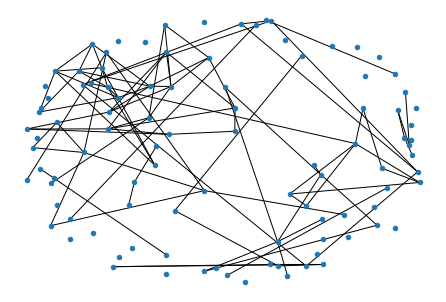

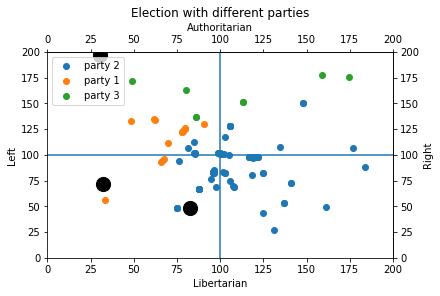

{1: 76, 0: 16, 2: 8}
Party 2 won with 76 votes of the 100 votes


0.7442872268795071

In [57]:
initial_parties = 3
initial_party_pos = []
for i in range(initial_parties):
     initial_party_pos.append((np.random.uniform(0,height_width), np.random.uniform(0,height_width)))
        
model = Partyvoter(initial_parties, height_width, num_voter, min_age, max_age, campaign_years, campaign_type, campaign_resources,
                        pull_of_parties, radius, barabasi, pull_of_connections, p_remove_connection, random_chance_add, alpha, b, initial_party_pos)
for step in range(num_steps):
    model.step()
positions = model.datacollector.get_agent_vars_dataframe()
nx.draw(model.G, linewidths=1, node_size= 20)
#distribution(model.G)
plots2(positions, initial_parties, model, num_steps, campaign_type, radius)
nx_comm.modularity(model.G, nx_comm.label_propagation_communities(model.G))

# Parties equally far away from the center and equally far away from each other

In [5]:
initial_party_pos =  [(50, 50),(50, 150),(150, 50),(150,150)]
initial_parties = len(initial_party_pos)

sims=1000

resultsapr = []
resultsplur = []
resultsinst = []
distancesapr = []
distancesplur = []
distancesinst = []

for sim in range(sims):
    model = Partyvoter(initial_parties, height_width, num_voter, min_age, max_age, campaign_years, campaign_type, campaign_resources,
                        pull_of_parties, radius, barabasi, pull_of_connections, p_remove_connection, random_chance_add, alpha, b, 
                        initial_party_pos)

    positions = model.datacollector.get_agent_vars_dataframe()
    progress = 0
    for step in range(num_steps):
        model.step()
        progress += 1
        #if progress % (num_steps / 10) == 0:
            #print("progress ", + progress / (num_steps/100), "%")

    #print(degree(model.G))
    positions = model.datacollector.get_agent_vars_dataframe()
    winnerapr = winners_approv(positions, approval_radius,num_steps, initial_parties, num_voter)
    winnerplur = winners_plur(positions,num_steps, initial_parties, num_voter)
    #print("Winner approval is party ", np.argmax(winnerapr[0])+1, "Total distance of voters from party: ",  winnerapr[1])
    #print("Winner plurality is party ", np.argmax(winnerplur[0])+1, "Total distance of voters from party: ", winnerplur[1])


    number_voters_parties, positions = plots_during_steps(positions, initial_parties, model, num_steps, campaign_type, radius, num_voter, height_width)

    #check which is the last party in the instant runoff race
    for i in range(initial_parties-1):
        number_voters_parties, positions = plots_during_instant_runoff(number_voters_parties, positions, initial_parties, model, num_steps, campaign_type, radius, num_voter, height_width)

    #compare to the position of the parties to check which party it is
    for i in range(len(initial_party_pos)):
        if initial_party_pos[i] == positions.iloc[-1]:

            instant_runoff_winner = i+1

    winnerinst = winners_instant_runoff(positions)
    #print("Winner instant runoff is party ", instant_runoff_winner, "Total distance of voters from party: ",  winnerinst)

    #print("")
    
    resultsapr.append(np.argmax(winnerapr[0])+1)
    resultsplur.append(np.argmax(winnerplur[0])+1)
    resultsinst.append(instant_runoff_winner)
    
    distancesapr.append(winnerapr[1])
    distancesplur.append(winnerplur[1])
    distancesinst.append(winnerinst)

    
print('Approval: ',resultsapr)
print('Plurality: ',resultsplur)
print('instant runoff: ',resultsinst)
print('Approval: ',distancesapr)
print('Plurality: ',distancesplur)
print('instant runoff: ',distancesinst)

Approval:  [1, 2, 2, 4, 4, 1, 3, 3, 2, 1]
Plurality:  [2, 2, 1, 4, 4, 1, 3, 3, 4, 1]
instant runoff:  [3, 2, 1, 4, 4, 1, 3, 3, 2, 1]
Approval:  [7775.674984510316, 6194.037149762367, 6918.524895271939, 5909.923721702785, 6532.425459348661, 6099.314265589473, 7284.708935338342, 6865.112966047501, 6799.106583615378, 6173.108746881647]
Plurality:  [8450.448889628817, 6194.037149762367, 6987.408610776626, 5909.923721702785, 6532.425459348661, 6099.314265589473, 7284.708935338342, 6865.112966047501, 7640.452569848488, 6173.108746881647]
instant runoff:  [7960.946001708832, 6194.037149762367, 6987.408610776626, 5909.923721702785, 6532.425459348661, 6099.314265589473, 7284.708935338342, 6865.112966047501, 6799.106583615378, 6173.108746881647]


In [6]:
distancesapr = np.array(distancesapr)
distancesplur = np.array(distancesplur)
distancesinst = np.array(distancesinst)

print('Approval: ', distancesapr.mean())
print('Plurality: ', distancesplur.mean())
print('instant runoff: ',distancesinst.mean())
print('Approval: ', np.std(distancesapr))
print('Plurality: ', np.std(distancesplur))
print('Instant runoff: ', np.std(distancesinst))

Approval:  6655.193770806841
Plurality:  6813.694131492472
instant runoff:  6680.609244077161
Approval:  557.7150408682925
Plurality:  762.7415839135282
Instant runoff:  599.5444405812533


In [79]:
#remove the elections where the outcome for every votings system is the same (not used)

resultsapr = np.array(resultsapr)
resultsplur = np.array(resultsplur)
resultsinst = np.array(resultsinst)

#print(resultsapr)
#print(resultsplur)
test = resultsapr == resultsplur
test2 = resultsapr == resultsinst
test3 = resultsplur == resultsinst
differ_results_election = np.all([test, test2, test3], axis=0)
results_same = np.count_nonzero(differ_results_election)
print(results_same)
results_different = sims-results_same
print(results_different)

different_results_indices = np.where(differ_results_election == False)[0]
#print(different_results_indices)
distancesapr_different_result = np.take(distancesapr, different_results_indices)
distancesplur_different_result = np.take(distancesplur, different_results_indices)
distancesinst_different_result = np.take(distancesinst, different_results_indices)

print('Approval: ', distancesapr_different_result.mean())
print('Plurality: ', distancesplur_different_result.mean())
print('instant runoff: ',distancesinst_different_result.mean())
print('Approval: ', np.std(distancesapr_different_result))
print('Plurality: ', np.std(distancesplur_different_result))
print('Instant runoff: ', np.std(distancesinst_different_result))


670
330
Approval:  7220.21958891339
Plurality:  7344.668402056658
instant runoff:  7410.099297580353
Approval:  455.61581040047383
Plurality:  478.68725827854774
Instant runoff:  527.7524588886973


# Parties equally far away from the center. Party 2 3 4 significantly closer to each other

In [74]:
initial_party_pos =  [(100, 29.29),(75, 166.14),(100, 170.71),(125,166.14)]


sims=1000

resultsapr = []
resultsplur = []
resultsinst = []
distancesapr = []
distancesplur = []
distancesinst = []

for sim in range(sims):
    model = Partyvoter(initial_parties, height_width, num_voter, min_age, max_age, campaign_years, campaign_type, campaign_resources,
                        pull_of_parties, radius, barabasi, pull_of_connections, p_remove_connection, random_chance_add, alpha, b, 
                        initial_party_pos)

    positions = model.datacollector.get_agent_vars_dataframe()
    progress = 0
    for step in range(num_steps):
        model.step()
        progress += 1
        #if progress % (num_steps / 10) == 0:
            #print("progress ", + progress / (num_steps/100), "%")

    #print(degree(model.G))
    positions = model.datacollector.get_agent_vars_dataframe()
    winnerapr = winners_approv(positions, approval_radius,num_steps, initial_parties, num_voter)
    winnerplur = winners_plur(positions,num_steps, initial_parties, num_voter)
    #print("Winner approval is party ", np.argmax(winnerapr[0])+1, "Total distance of voters from party: ",  winnerapr[1])
    #print("Winner plurality is party ", np.argmax(winnerplur[0])+1, "Total distance of voters from party: ", winnerplur[1])


    number_voters_parties, positions = plots_during_steps(positions, initial_parties, model, num_steps, campaign_type, radius, num_voter, height_width)

    #check which is the last party in the instant runoff race
    for i in range(initial_parties-1):
        number_voters_parties, positions = plots_during_instant_runoff(number_voters_parties, positions, initial_parties, model, num_steps, campaign_type, radius, num_voter, height_width)

    #compare to the position of the parties to check which party it is
    for i in range(len(initial_party_pos)):
        if initial_party_pos[i] == positions.iloc[-1]:

            instant_runoff_winner = i+1

    winnerinst = winners_instant_runoff(positions)
    #print("Winner instant runoff is party ", instant_runoff_winner, "Total distance of voters from party: ",  winnerinst)

    #print("")
    
    resultsapr.append(np.argmax(winnerapr[0])+1)
    resultsplur.append(np.argmax(winnerplur[0])+1)
    resultsinst.append(instant_runoff_winner)
    
    distancesapr.append(winnerapr[1])
    distancesplur.append(winnerplur[1])
    distancesinst.append(winnerinst)

    
print('Approval: ',resultsapr)
print('Plurality: ',resultsplur)
print('instant runoff: ',resultsinst)
print('Approval: ',distancesapr)
print('Plurality: ',distancesplur)
print('instant runoff: ',distancesinst)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [75]:
distancesapr = np.array(distancesapr)
distancesplur = np.array(distancesplur)
distancesinst = np.array(distancesinst)

print('Approval: ', distancesapr.mean())
print('Plurality: ', distancesplur.mean())
print('instant runoff: ',distancesinst.mean())
print('Approval: ', np.std(distancesapr))
print('Plurality: ', np.std(distancesplur))
print('Instant runoff: ', np.std(distancesinst))

Approval:  6928.717900029266
Plurality:  7278.3766379008575
instant runoff:  6944.460792107463
Approval:  706.7227823440026
Plurality:  1001.495281560534
Instant runoff:  729.6012018456178


In [76]:
#remove the elections where the outcome for every votings system is the same (not used in report)

resultsapr = np.array(resultsapr)
resultsplur = np.array(resultsplur)
resultsinst = np.array(resultsinst)

#print(resultsapr)
#print(resultsplur)
test = resultsapr == resultsplur
test2 = resultsapr == resultsinst
test3 = resultsplur == resultsinst
differ_results_election = np.all([test, test2, test3], axis=0)
results_same = np.count_nonzero(differ_results_election)
print(results_same)
results_different = sims-results_same
print(results_different)

different_results_indices = np.where(differ_results_election == False)[0]
#print(different_results_indices)
distancesapr_different_result = np.take(distancesapr, different_results_indices)
distancesplur_different_result = np.take(distancesplur, different_results_indices)
distancesinst_different_result = np.take(distancesinst, different_results_indices)

print('Approval: ', distancesapr_different_result.mean())
print('Plurality: ', distancesplur_different_result.mean())
print('instant runoff: ',distancesinst_different_result.mean())
print('Approval: ', np.std(distancesapr_different_result))
print('Plurality: ', np.std(distancesplur_different_result))
print('Instant runoff: ', np.std(distancesinst_different_result))


522
478
Approval:  7008.039307341271
Plurality:  7739.542943055895
instant runoff:  7040.974228006955
Approval:  696.2221105477721
Plurality:  1069.0081774942412
Instant runoff:  740.0544652286297
